In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import time

from sklearn.metrics import mean_absolute_error

In [ ]:
limit_ListPrice = 1800
price_segment = 100
customer_traffic_segment = 0.2778 #5/(limit_ListPrice/price_segment)
competitiveness_segment = 0.1389 #2.5/(limit_ListPrice/price_segment)
epsilon = 0.4
moving_avg_100= {
  "proposed100": [],
  "timestamp100":[],
  "profit100": []
}

# Dynamic Pricing with Reinforcement Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/preprocessed_data_v3_training.csv")
df

,DWHotelID,Unnamed: 0,w,Date,ListPriceTRY,PurchaseAmountTRY,RatingTripA,ProfitRate,featureScore,Date_year,Date_week,rooms_old,#rooms,empty_rooms,rewardrate
0,2.0,9216,3.0,2013-21,265.333333,199.000000,3.5,0.333333,1.078785,2013,21,17.0,119.0,116.001,0.571834
1,2.0,9217,0.0,2013-22,336.000000,252.000000,3.5,0.333333,1.078785,2013,22,17.0,119.0,119.001,0.705876
2,2.0,9218,5.0,2013-23,336.000000,252.000000,3.5,0.333333,1.078785,2013,23,17.0,119.0,114.001,0.736836
3,2.0,9219,3.0,2013-24,846.666667,689.000000,3.5,0.228834,1.078785,2013,24,17.0,119.0,116.001,1.359184
4,2.0,9220,3.0,2013-25,645.333333,538.000000,3.5,0.199504,1.078785,2013,25,17.0,119.0,116.001,0.925279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8677,880.0,1265,12.0,2019-26,1401.500000,1091.416667,4.5,0.284111,1.030392,2019,26,2.0,66.0,54.001,5.742178
8678,880.0,1267,29.0,2019-28,1594.034483,1167.655172,4.5,0.365159,1.030392,2019,28,2.0,66.0,37.001,11.523454
8679,880.0,1269,14.0,2019-30,1650.714286,1175.500000,4.5,0.404266,1.030392,2019,30,2.0,66.0,52.001,9.138561
8680,880.0,1273,14.0,2019-34,1781.428571,1311.357143,4.5,0.358462,1.030392,2019,34,2.0,66.0,52.001,9.039661


In [ ]:
validation = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/preprocessed_data_v3_validation.csv")
validation

,Index,DWHotelID,Unnamed: 0,w,Date,ListPriceTRY,PurchaseAmountTRY,RatingTripA,ProfitRate,featureScore,Date_year,Date_week,rooms_old,#rooms,empty_rooms,rewardrate
0,9358,2.0,9358,53.0,2021-37,1530.245283,1120.320755,3.5,0.365899,1.078785,2021,37,17.0,119.0,66.001,6.210884
1,401,3.0,401,22.0,2019-26,1395.909091,1185.000000,4.5,0.177982,1.963910,2019,26,53.0,371.0,349.001,0.604322
2,11375,6.0,11375,3.0,2021-38,313.666667,253.333333,3.5,0.238158,0.469892,2021,38,4.0,28.0,25.001,2.413237
3,1581,10.0,1581,20.0,2021-36,1637.850000,1089.050000,4.0,0.503925,0.853482,2021,36,1.0,21.0,1.001,548.251748
4,1439,11.0,1439,0.0,2021-38,1522.000000,882.600000,4.5,0.724450,0.674638,2021,38,2.0,14.0,14.001,45.668167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,11087,538.0,11087,13.0,2021-38,1346.153846,961.538462,4.5,0.400000,0.801150,2021,38,25.0,175.0,162.001,2.374154
73,1871,540.0,1871,8.0,2021-38,456.250000,342.000000,3.0,0.334064,0.611310,2021,38,5.0,35.0,27.001,4.231325
74,7907,589.0,7907,2.0,2021-26,918.500000,698.000000,4.5,0.315903,0.643136,2021,26,21.0,147.0,145.001,1.520679
75,863,701.0,863,0.0,2021-38,1469.230769,1186.384615,4.5,0.238410,1.346912,2021,38,5.0,35.0,35.001,8.081088


In [ ]:
print('Max Purchase Amount:', df['PurchaseAmountTRY'].max() , 'Min Purchase Amount:', df['PurchaseAmountTRY'].min())
print('Max List Price:', df['ListPriceTRY'].max() , 'Min List Price:', df['ListPriceTRY'].min() )
print('Max Rate:', df['RatingTripA'].max(), 'Min Rate:', df['RatingTripA'].min())
print('Max Feature Score:', df['featureScore'].max() , 'Min Feature Score:', df['featureScore'].min())
print('Max Room Count:', df['empty_rooms'].max() , 'Min Room Count:', df['empty_rooms'].min())

Max Purchase Amount: 1660.5 Min Purchase Amount: 34.0
Max List Price: 1800.0 Min List Price: 37.66666666666666
Max Rate: 5.0 Min Rate: 2.5
Max Feature Score: 2.2538542161050463 Min Feature Score: 0.469892026578073
Max Room Count: 488.001 Min Room Count: 0.001


### UTILITY FUNCTIONS

In [ ]:
def round_specific(x, precision, base):
  return round(base * round(float(x)/base),precision)

def round_specific_series(x, precision, base):
  return round(base * round(x/base),precision)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(data_frame):

  print("*Number of Sales: ",data_frame.shape[0])
  print("*Mean Absolute Error: ", mean_absolute_error(data_frame['ListPriceTRY'],data_frame['list_price']));
 
  print("*Mean Absolute Percentage Error ", mean_absolute_percentage_error(data_frame['ListPriceTRY'],data_frame['list_price']));
 
  print("*Mean of Recommended List Prices:", data_frame['list_price'].mean())
  print("*Mean of Original List Prices:", data_frame['ListPriceTRY'].mean())

  print("*Standard Deviation of Recommended List Prices:", data_frame['list_price'].std())
  print("*Standard Deviation of Original List Prices:", data_frame['ListPriceTRY'].std())
 
  return

#### Reward Functions

In [ ]:
def proposed(list_price, purchase, empty_rooms):
    return (list_price-purchase)/empty_rooms
def timestamp(list_price, purchase, empty_rooms,list_price2, purchase2, empty_rooms2):
    return (list_price2-purchase2)/empty_rooms2 - (list_price-purchase)/empty_rooms
def profit(list_price,purchase):
    return (list_price-purchase)/(purchase+0.001)

#### Draw Functions

In [ ]:
def draw(moving_avg,moving_avg_val, moving_avg_all, df, validation):
    print("Validation")
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.plot([i for i in range(len(moving_avg_val))], moving_avg_val)
    plt.ylabel(f"Reward 100ma")
    plt.xlabel("episode #")
    plt.show()

    validation = validation[['ListPriceTRY','list_price']]
    plt.figure();
    plt.rcParams['figure.figsize'] = [20, 5]
    validation.plot.area(stacked=False);
    plt.show()

    print("All Dataset")
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.plot([i for i in range(len(moving_avg_all))],moving_avg_all)
    plt.ylabel(f"Reward 100ma")
    plt.xlabel("episode #")
    plt.show()

    df2 = pd.concat([df,validation])
    df22 = df2[['ListPriceTRY','list_price']]
    plt.figure();
    plt.rcParams['figure.figsize'] = [20, 5]
    df22.plot.area(stacked=False);
    plt.show()
    print("\n\n\|")
    print_metrics(validation)
    print("|")
    print_metrics(df2)
    print("|")
    print_metrics(df)

### AGENT CLASS: SALE
 * Initializes first list price according to purchase amount
 * Takes actions: +10%, 0, -5%

In [ ]:
class Sale:
    def __init__(self, purchase, customer_traffic, competitiveness, empty_rooms):
        self.profit = round_specific(np.random.rand()*0.2, 2, 0.01)
        self.purchase = purchase
        if self.purchase > limit_ListPrice:
            self.purchase = limit_ListPrice
        if self.purchase < 0:
            self.purchase = 0
        
        self.list_price = self.purchase + self.purchase*self.profit
        self.list_price = round_specific(self.list_price, 0, price_segment)
        if self.list_price > limit_ListPrice:
            self.list_price = limit_ListPrice
        if self.list_price < 0:
            self.list_price = 0

        self.customer_traffic = customer_traffic
        self.competitiveness = competitiveness
        self.empty_rooms = empty_rooms
    
    def __str__(self):
        return f"{self.profit}"
    
    def __sub__(self,other):
        return self.profit - other.profit
    
    def action(self, choice):
        if choice == 0:
            self.change(-5) # profiti %5 indir
        elif choice == 1:
            self.change(0) 
        elif choice == 2:
            self.change(+10) 
        """
        elif choice == 3:
            self.change(+5) 
        elif choice == 4:
            self.change(+10) # profiti %10 arttir 
        """
    
    def change(self, p=False):
        if not p:
            self.profit = round_specific(np.random.rand(), 2, 0.01)
        else:
            self.profit = self.profit + (p/100)
            
        self.list_price = self.purchase + self.purchase*self.profit 
        self.list_price = round_specific(self.list_price, 0, price_segment)
        if self.list_price > limit_ListPrice:
            self.list_price = limit_ListPrice
        if self.list_price < 0:
            self.list_price = 0

### LOAD Q TABLE

In [ ]:
q_table_main = np.load('/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/qtable/q_table_100_1800_3acts.npy',allow_pickle='TRUE').item()

### RL FUNCTIONS

#### 1- RL WITH PROPOSED REWARD FUNCTION

In [ ]:
def RL_proposed(HM_EPISODES, epsilon, df, q_table):
    EPS_DECAY = 0.998
    SHOW_EVERY = 1
    LEARNING_RATE = 0.1
    DISCOUNT = 0.95
    df['list_price']=np.nan

    episode_rewards = []

    for episode in range(HM_EPISODES):
        # initalize agent
        sale = df.iloc[episode]
        
        purchase = sale['PurchaseAmountTRY']
        purchase = round_specific(purchase, 0, price_segment)
        
        customer_traffic = sale['RatingTripA']
        customer_traffic = round_specific(customer_traffic, 1, customer_traffic_segment)
        
        competitiveness = sale['featureScore']
        competitiveness = round_specific(competitiveness, 2, competitiveness_segment)
        
        empty_rooms = sale['empty_rooms']
        
        # get first list price 
        agent = Sale(purchase, customer_traffic, competitiveness, empty_rooms)
        
        list_price = agent.list_price

        episode_reward = 0

        for i in range(200):
            obs = (purchase, list_price, customer_traffic, competitiveness)
            
            if np.random.random() > epsilon:
                # GET THE ACTION
                action = np.argmax(q_table[obs])
            else:
                action = np.random.randint(0, 3)
            
            # Take the action!
            agent.action(action)
            
            ##############################
            # REWARD FUNCTION
            new_obs = (agent.purchase, agent.list_price, agent.customer_traffic, agent.competitiveness)
            max_future_q = np.max(q_table[new_obs])
   
            current_q = q_table[obs][action]
            
            rewardrate = proposed(agent.list_price, agent.purchase,agent.empty_rooms)
            
            if rewardrate < 1:
                reward = -300
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            elif rewardrate < 10 or rewardrate > 100:
                new_q = rewardrate
                reward = 25
            else:
                reward = -1
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            
            q_table[obs][action] = new_q

            episode_reward += reward
            if reward ==25:
                break
        df['list_price'].iloc[episode] = agent.list_price
        #print(episode_reward)
        episode_rewards.append(episode_reward)
        epsilon *= EPS_DECAY

    moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')
    return df, moving_avg

#### 2- RL WITH TIMESTAMP REWARD FUNCTION


In [ ]:
def RL_timestamp(HM_EPISODES, epsilon, df, q_table):
    drop = []
    EPS_DECAY = 0.998
    SHOW_EVERY = 100
    LEARNING_RATE = 0.1
    DISCOUNT = 0.95
    df['list_price']=np.nan

    episode_rewards = []

    for episode in range(HM_EPISODES):
        # initalize agent
        sale = df.iloc[episode]
        old_sale = df.iloc[episode-1]

        if (episode == 0) or sale["DWHotelID"] != old_sale["DWHotelID"] :
          drop.append(episode)
          old_sale = sale
          old_sale["list_price"] = old_sale["ListPriceTRY"]
        
        purchase = sale['PurchaseAmountTRY']
        purchase = round_specific(purchase, 0, price_segment)
        
        customer_traffic = sale['RatingTripA']
        customer_traffic = round_specific(customer_traffic, 1, customer_traffic_segment)
        
        competitiveness = sale['featureScore']
        competitiveness = round_specific(competitiveness, 2, competitiveness_segment)
        
        empty_rooms = sale['empty_rooms']

        # get first list price 
        agent = Sale(purchase, customer_traffic, competitiveness, empty_rooms)
        
        list_price = agent.list_price

        episode_reward = 0


        for i in range(200):
            obs = (purchase, list_price, customer_traffic, competitiveness)
            
            if np.random.random() > epsilon:
                # GET THE ACTION
                action = np.argmax(q_table[obs])
            else:
                action = np.random.randint(0, 3)
            
            # Take the action!
            agent.action(action)

             ##############################
            # REWARD FUNCTION
            new_obs = (agent.purchase, agent.list_price, agent.customer_traffic, agent.competitiveness)
            max_future_q = np.max(q_table[new_obs])
            current_q = q_table[obs][action]
            
            rewardrate = timestamp(agent.list_price, agent.purchase,agent.empty_rooms, old_sale["list_price"], old_sale["PurchaseAmountTRY"], old_sale["empty_rooms"])

            if rewardrate < 1000 and rewardrate > 0:
                reward = -300
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            elif rewardrate < 0:
                new_q = rewardrate
                reward = 25
            else:
                reward = -1
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            
            q_table[obs][action] = new_q

            episode_reward += reward
            if reward ==25:
                break

        df['list_price'].iloc[episode] = agent.list_price
        #print(episode_reward)
        episode_rewards.append(episode_reward)
        epsilon *= EPS_DECAY

    moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')
    return df, moving_avg


#### 3- RL WITH PROFIT REWARD FUNCTION


In [ ]:
def RL_profit(HM_EPISODES, epsilon, df, q_table):
    EPS_DECAY = 0.998
    SHOW_EVERY = 1
    LEARNING_RATE = 0.1
    DISCOUNT = 0.95
    df['list_price']=np.nan

    episode_rewards = []

    for episode in range(HM_EPISODES):
        # initalize agent
        sale = df.iloc[episode]
        
        purchase = sale['PurchaseAmountTRY']
        purchase = round_specific(purchase, 0, price_segment)
        
        customer_traffic = sale['RatingTripA']
        customer_traffic = round_specific(customer_traffic, 1, customer_traffic_segment)
        
        competitiveness = sale['featureScore']
        competitiveness = round_specific(competitiveness, 2, competitiveness_segment)
        
        empty_rooms = sale['empty_rooms']
        
        # get first list price 
        agent = Sale(purchase, customer_traffic, competitiveness, empty_rooms)
        
        list_price = agent.list_price

        episode_reward = 0

        for i in range(200):
            obs = (purchase, list_price, customer_traffic, competitiveness)
            
            if np.random.random() > epsilon:
                # GET THE ACTION
                action = np.argmax(q_table[obs])
            else:
                action = np.random.randint(0, 3)
            
            # Take the action!
            agent.action(action)
            
            ##############################
            # REWARD FUNCTION
            new_obs = (agent.purchase, agent.list_price, agent.customer_traffic, agent.competitiveness)
            max_future_q = np.max(q_table[new_obs])
   
            current_q = q_table[obs][action]
            
            rewardrate = profit(agent.list_price, agent.purchase)
            
            if rewardrate <= 0:
                reward = -300
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            elif rewardrate < 0.08 or rewardrate > 0.33:
                new_q = rewardrate
                reward = 25
            else:
                reward = -1
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            
            q_table[obs][action] = new_q

            episode_reward += reward
            if reward ==25:
                break
        df['list_price'].iloc[episode] = agent.list_price
        #print(episode_reward)
        episode_rewards.append(episode_reward)
        epsilon *= EPS_DECAY

    moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')
    return df, moving_avg

#### RUN RL ALGORITHMS

In [ ]:
df.reset_index()

df_proposed = df.copy()
validation_proposed = validation.copy()
q_table_proposed = q_table_main.copy()

df_proposed, moving_avg_prop = RL_proposed(df_proposed.shape[0], epsilon, df_proposed, q_table_proposed)

validation_proposed, moving_avg_propval = RL_proposed(validation_proposed.shape[0], epsilon, validation_proposed, q_table_proposed)

moving_avg_prop_all = np.concatenate([moving_avg_prop, moving_avg_propval])
moving_avg_100['proposed100']= [moving_avg_prop, moving_avg_propval]


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
df_timestamp = df.copy()
validation_timestamp = validation.copy()
q_table_timestamp = q_table_main.copy()

df_timestamp, moving_avg_timestamp = RL_timestamp(df_timestamp.shape[0], epsilon, df_timestamp, q_table_timestamp)

validation_timestamp, moving_avg_timestampval = RL_timestamp(validation_timestamp.shape[0], epsilon, validation_timestamp, q_table_timestamp)

moving_avg_timestamp_all = np.concatenate([moving_avg_timestamp, moving_avg_timestampval])
moving_avg_100['timestamp100']= [moving_avg_timestamp, moving_avg_timestampval]

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
df_profit = df.copy()
validation_profit = validation.copy()
q_table_profit = q_table_main.copy()

df_profit, moving_avg_profit = RL_profit(df_profit.shape[0], epsilon, df_profit, q_table_profit)

validation_profit, moving_avg_profitval = RL_profit(validation_profit.shape[0], epsilon, validation_profit, q_table_profit)

moving_avg_profit_all = np.concatenate([moving_avg_profit, moving_avg_profitval])
moving_avg_100['profit100']= [moving_avg_profit, moving_avg_profitval]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### DRAW AND PRINT METRICS

Validation


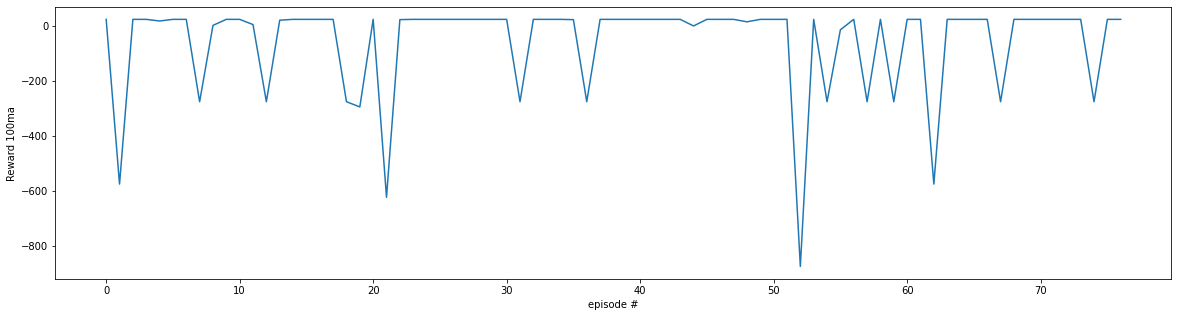

<Figure size 1440x360 with 0 Axes>

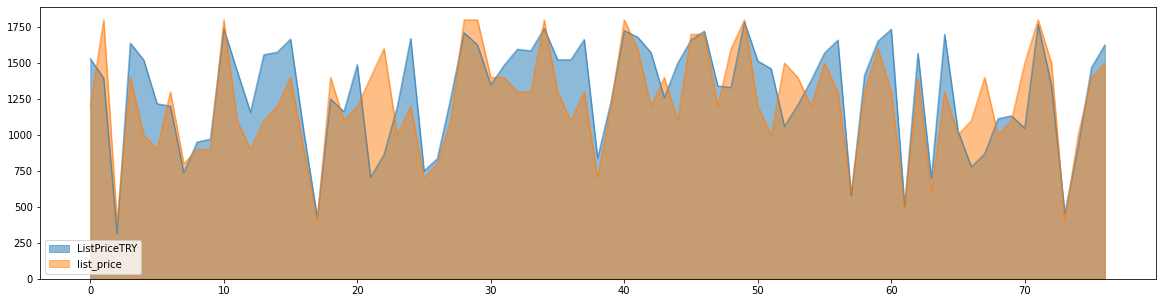

All Dataset


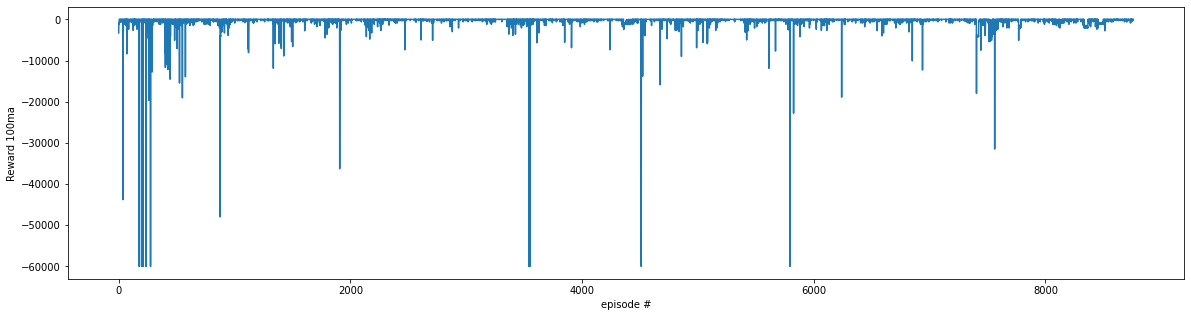

<Figure size 1440x360 with 0 Axes>

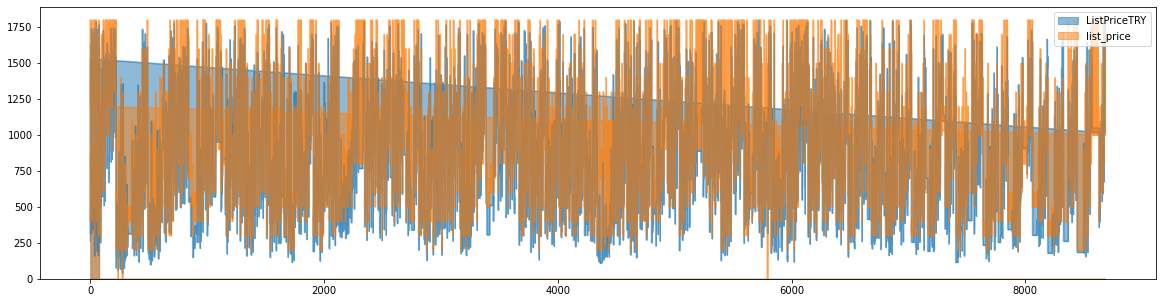



\|
*Number of Sales:  77
*Mean Absolute Error:  207.93606265268326
*Mean Absolute Percentage Error  17.00162894137734
*Mean of Recommended List Prices: 1231.1688311688313
*Mean of Original List Prices: 1298.0081701827344
*Standard Deviation of Recommended List Prices: 356.2449409649063
*Standard Deviation of Original List Prices: 376.7728562697772
|
*Number of Sales:  8759
*Mean Absolute Error:  157.0628242494618
*Mean Absolute Percentage Error  27.39747831781739
*Mean of Recommended List Prices: 895.0907637858203
*Mean of Original List Prices: 781.8926231280282
*Standard Deviation of Recommended List Prices: 434.6056138650203
*Standard Deviation of Original List Prices: 417.3028134483623
|
*Number of Sales:  8682
*Mean Absolute Error:  156.6116333536949
*Mean Absolute Percentage Error  27.489678318046124
*Mean of Recommended List Prices: 892.1101128772173
*Mean of Original List Prices: 777.3152334570752
*Standard Deviation of Recommended List Prices: 434.09170853568816
*Standard Dev

In [ ]:
draw(moving_avg_prop,moving_avg_propval, moving_avg_prop_all, df_proposed, validation_proposed)


Validation


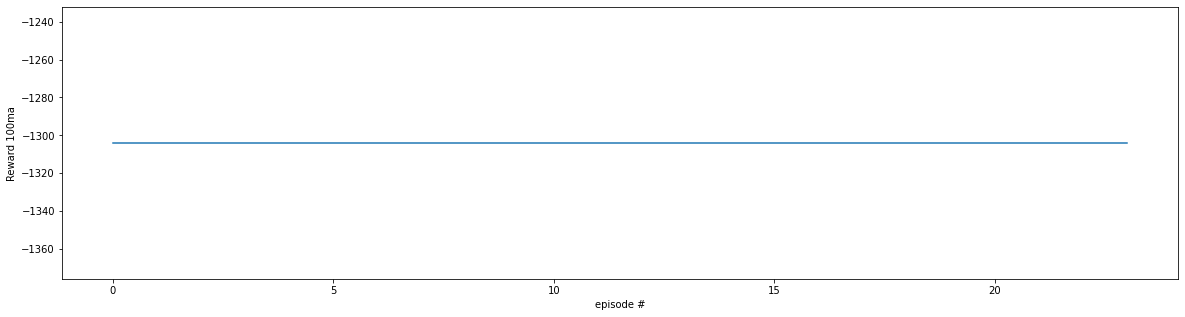

<Figure size 1440x360 with 0 Axes>

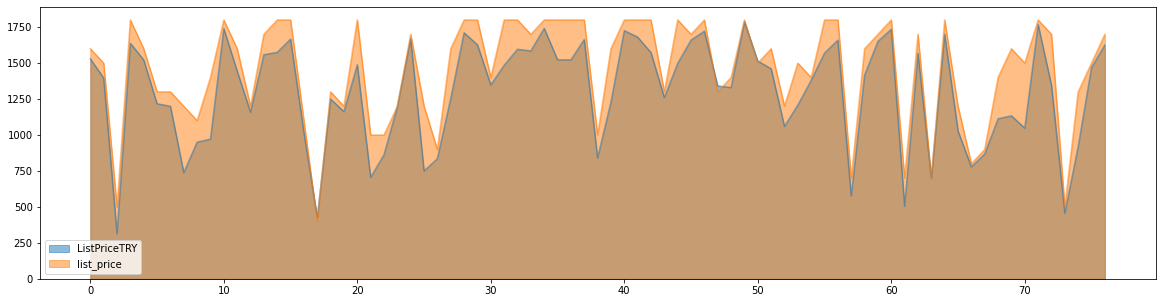

All Dataset


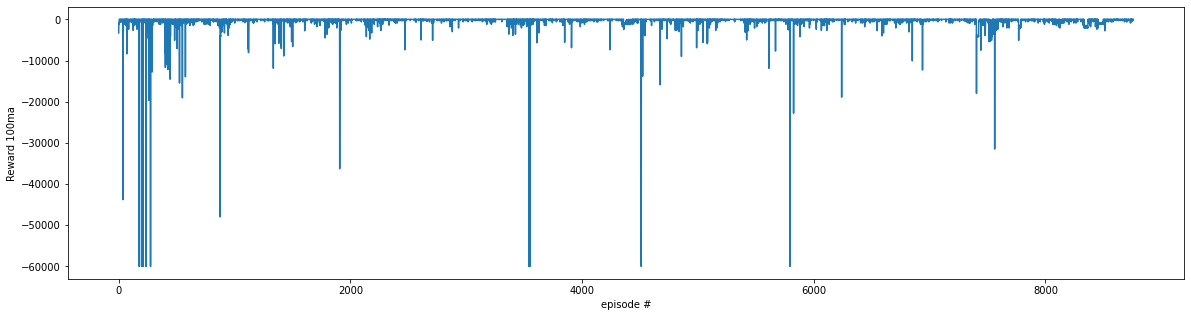

<Figure size 1440x360 with 0 Axes>

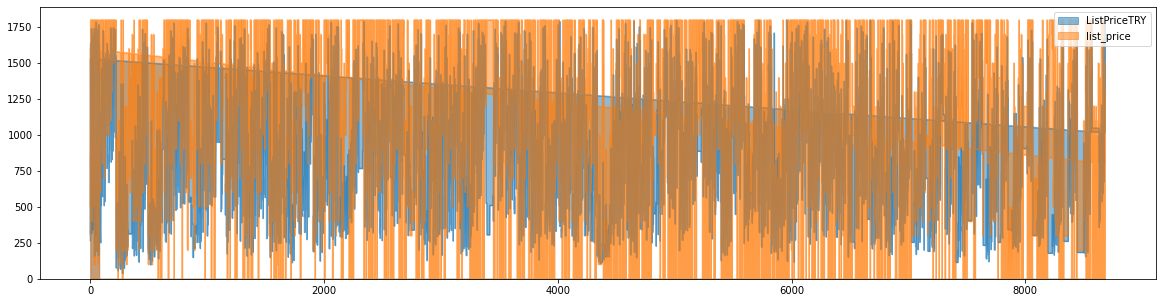



\|
*Number of Sales:  77
*Mean Absolute Error:  153.48205676203793
*Mean Absolute Percentage Error  14.024266910122021
*Mean of Recommended List Prices: 1449.3506493506493
*Mean of Original List Prices: 1298.0081701827344
*Standard Deviation of Recommended List Prices: 375.0871395680072
*Standard Deviation of Original List Prices: 376.7728562697772
|
*Number of Sales:  8759
*Mean Absolute Error:  431.38664280320586
*Mean Absolute Percentage Error  81.29410124580617
*Mean of Recommended List Prices: 1075.4309852722913
*Mean of Original List Prices: 781.8926231280282
*Standard Deviation of Recommended List Prices: 565.9510673593517
*Standard Deviation of Original List Prices: 417.3028134483623
|
*Number of Sales:  8682
*Mean Absolute Error:  433.85135751469744
*Mean Absolute Percentage Error  81.8907123082166
*Mean of Recommended List Prices: 1072.1147201105737
*Mean of Original List Prices: 777.3152334570752
*Standard Deviation of Recommended List Prices: 566.2674209634081
*Standard D

In [ ]:
draw(moving_avg_timestamp,moving_avg_timestampval, moving_avg_prop_all, df_timestamp, validation_timestamp)

Validation


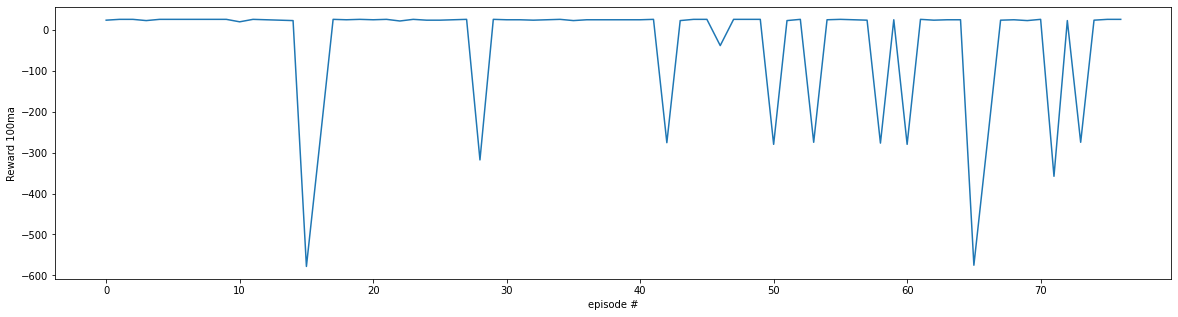

<Figure size 1440x360 with 0 Axes>

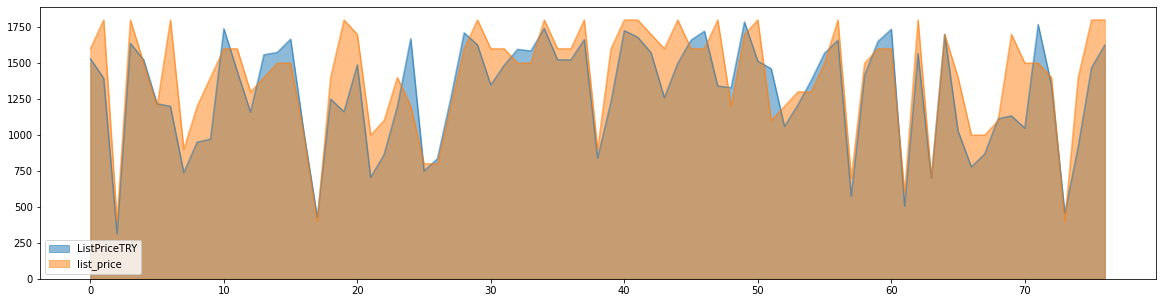

All Dataset


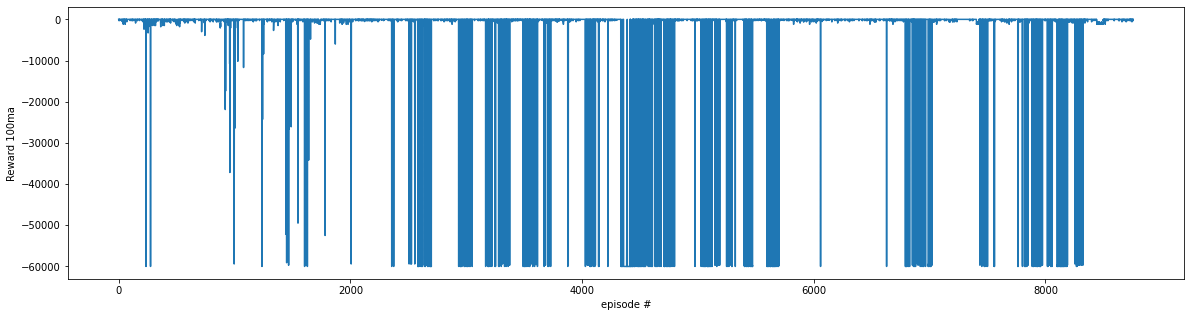

<Figure size 1440x360 with 0 Axes>

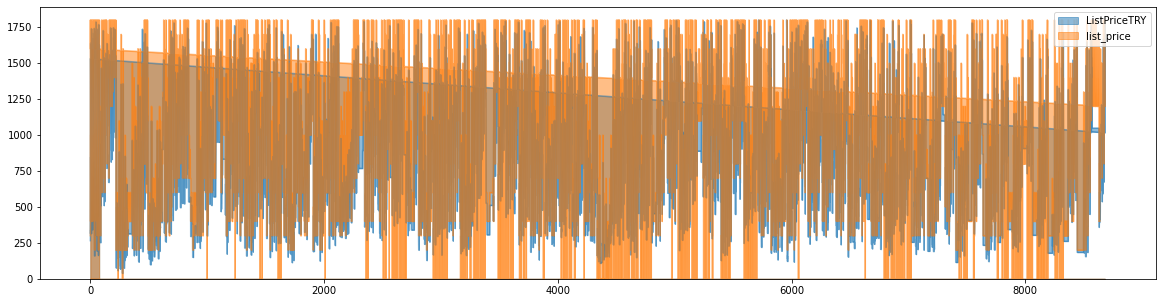



\|
*Number of Sales:  77
*Mean Absolute Error:  180.13417114189713
*Mean Absolute Percentage Error  15.290736913341489
*Mean of Recommended List Prices: 1402.5974025974026
*Mean of Original List Prices: 1298.0081701827344
*Standard Deviation of Recommended List Prices: 374.85928095684187
*Standard Deviation of Original List Prices: 376.7728562697772
|
*Number of Sales:  8759
*Mean Absolute Error:  222.51281591993623
*Mean Absolute Percentage Error  32.05450983956985
*Mean of Recommended List Prices: 904.132891882635
*Mean of Original List Prices: 781.8926231280282
*Standard Deviation of Recommended List Prices: 522.4149473136522
*Standard Deviation of Original List Prices: 417.3028134483623
|
*Number of Sales:  8682
*Mean Absolute Error:  222.88866890863807
*Mean Absolute Percentage Error  32.203186471143184
*Mean of Recommended List Prices: 899.7120479152269
*Mean of Original List Prices: 777.3152334570752
*Standard Deviation of Recommended List Prices: 521.4254429770185
*Standard D

In [ ]:
draw(moving_avg_profit,moving_avg_profitval, moving_avg_profit_all, df_profit, validation_profit)

In [ ]:
moving_avg_100

{'profit100': [array([  25., -275.,   25., ...,   23.,   25., -275.]),
  array([  23.,   25.,   25.,   22.,   25.,   25.,   25.,   25.,   25.,
           25.,   19.,   25.,   24.,   23.,   22., -578., -278.,   25.,
           24.,   25.,   24.,   25.,   21.,   25.,   23.,   23.,   24.,
           25., -318.,   25.,   24.,   24.,   23.,   24.,   25.,   22.,
           24.,   24.,   24.,   24.,   24.,   25., -276.,   22.,   25.,
           25.,  -39.,   25.,   25.,   25., -280.,   22.,   25., -275.,
           24.,   25.,   24.,   23., -277.,   24., -280.,   25.,   23.,
           24.,   24., -575., -278.,   23.,   24.,   22.,   25., -358.,
           22., -275.,   23.,   25.,   25.])],
 'proposed100': [array([-3275.,  -875.,  -875., ...,    25.,    25.,  -275.]),
  array([  25., -575.,   25.,   25.,   19.,   25.,   25., -275.,    3.,
           25.,   25.,    6., -275.,   22.,   25.,   25.,   25.,   25.,
         -275., -294.,   25., -623.,   24.,   25.,   25.,   25.,   25.,
           

In [23]:
np.save('/content/drive/My Drive/Colab Notebooks/dynamic_pricing/results/moving_avg_100.npy',moving_avg_100)